## Hate Speech Detection & Models Interpretability

This notebook was create based on the work develop by Davidson et al. 2017. on "Automated Hate Speech Detection and the Problem of Offensive Language"

See the paper: [Automated Hate Speech Detection and the Problem of Offensive Language](https://arxiv.org/pdf/1703.04009.pdf)

Github: [davidson-hate-speech-and-offensive-language](https://github.com/t-davidson/hate-speech-and-offensive-language)

In [1]:
# for data
import pandas as pd
import numpy as np

# for bag of words
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# for explainer
from lime import lime_text
import shap

# for model training and prediction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# for model evaluation
from sklearn.metrics import classification_report

# for processing
import re
import nltk
from textstat.textstat import *
from nltk.stem.porter import *

# for plotting
from wordcloud import WordCloud
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/mirianfrs/nltk_data...
[nltk_data]    |   Package movie_

True

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Loading the data

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv")

In [5]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [6]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


### Columns key

- count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
- hate_speech = number of CF users who judged the tweet to be hate speech.
- offensive_language = number of CF users who judged the tweet to be offensive.
- neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
- class = class label for majority of CF users.
    - 0 - hate speech
    - 1 - offensive  language
    - 2 - neither
- tweet = raw tweet text


In [7]:
tweets=df.tweet

### Feature generation : Preprocessing - tokenizer, stemming, vectorizer with Tf-idf

In [9]:
stopwords = stopwords = nltk.corpus.stopwords.words("english")
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                       '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text


def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens


def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()


##### Vectorizer with Tf-idf

In [11]:

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
)

In [12]:
# Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v: i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
# keys are indices; values are IDF scores
idf_dict = {i: idf_vals[i] for i in vocab.values()}


Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.


### Word Cloud 

fit_transform vectorizer (tweets) 

In [13]:
#create the wordcloud. 
temp = vectorizer.fit_transform(tweets)
weights = [(word, temp.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

In [14]:
w = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf', background_color="white",
              width=3000, height=2000, max_words=2000).fit_words(dict(weights))


(-0.5, 2999.5, 1999.5, -0.5)

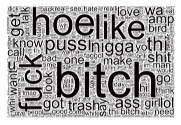

In [15]:
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")


w.recolor(color_func=black_color_func)
plt.figure(figsize=(3, 3))  # 20,15
plt.imshow(w, interpolation="bilinear")
plt.axis('off')
# plt.savefig('hatespeech_wordcloud.png')


### Pos vectorizer

In [16]:
# Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [17]:
# We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
)


In [18]:
# Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v: i for i, v in enumerate(pos_vectorizer.get_feature_names())}


### Final Sparse Matrix from Tfidf

### Final Matrix is composed by vectorizer from inital tweets, pos vectorization using more information about tweets and features generated by sentimental analysis

In [19]:
#Now join them all up
M = np.concatenate([tfidf,pos],axis=1)

In [20]:
M.shape

(24783, 11155)

In [21]:
# Finally get a list of variable names
variables = ['']*len(vocab)
for k, v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k, v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables
feature_names


['ab',
 'abil',
 'abl',
 'abo',
 'abort',
 'abov',
 'absolut',
 'abt',
 'abu',
 'abus',
 'accent',
 'accept',
 'accid',
 'accident',
 'accord',
 'account',
 'accur',
 'acknowledg',
 'across',
 'act',
 'act like',
 'act like bitch',
 'act like hoe',
 'act like pussi',
 'actin',
 'actin like',
 'action',
 'activ',
 'actor',
 'actual',
 'actual fuck',
 'ad',
 'adam',
 'add',
 'addict',
 'address',
 'admit',
 'adopt',
 'ador',
 'adult',
 'advanc',
 'advic',
 'ae',
 'af',
 'affect',
 'afford',
 'afraid',
 'african',
 'afterward',
 'ag',
 'age',
 'ago',
 'agre',
 'ah',
 'ah bitch',
 'aha',
 'ahaha',
 'ahead',
 'ahh',
 'ahhh',
 'aid',
 'aim',
 'ainn',
 'aint',
 'aint bitch',
 'aint even',
 'aint fuck',
 'aint fuckin',
 'aint get',
 'aint got',
 'aint hoe',
 'aint hoe get',
 'aint loyal',
 'aint never',
 'aint nobodi',
 'aint noth',
 'aint shit',
 'aint shit bitch',
 'air',
 'aka',
 'al',
 'al qaeda',
 'alabama',
 'alarm',
 'albino',
 'album',
 'alcohol',
 'alert',
 'alex',
 'alex smith',
 'al

### Running the model

In [22]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [23]:
X.head()


,0,1,2,3,4,5,6,7,8,9,...,11145,11146,11147,11148,11149,11150,11151,11152,11153,11154
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [25]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,11145,11146,11147,11148,11149,11150,11151,11152,11153,11154
2281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model 1: Logistic Regression

In [26]:
logreg = LogisticRegression(verbose=1, random_state=0, class_weight='balanced', penalty="l2", C=0.01, solver='newton-cg')
model = logreg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min finished


### Model 2: SVM

In [27]:
svm = SGDClassifier(verbose=1, random_state=0, class_weight='balanced', penalty="l2")
model2 = svm.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 931.77, NNZs: 8966, Bias: -176.368961, T: 22304, Avg. loss: 82.925717
Total training time: 1.34 seconds.
-- Epoch 2
Norm: 573.45, NNZs: 9606, Bias: -148.566601, T: 44608, Avg. loss: 14.158230
Total training time: 2.49 seconds.
-- Epoch 3
Norm: 434.30, NNZs: 9824, Bias: -121.345400, T: 66912, Avg. loss: 5.615556
Total training time: 3.59 seconds.
-- Epoch 4
Norm: 360.20, NNZs: 9923, Bias: -104.085196, T: 89216, Avg. loss: 3.670976
Total training time: 4.78 seconds.
-- Epoch 5
Norm: 309.45, NNZs: 9983, Bias: -84.699124, T: 111520, Avg. loss: 2.436998
Total training time: 6.02 seconds.
-- Epoch 6
Norm: 275.02, NNZs: 10026, Bias: -74.613066, T: 133824, Avg. loss: 1.837309
Total training time: 7.85 seconds.
-- Epoch 7
Norm: 246.37, NNZs: 10042, Bias: -68.214559, T: 156128, Avg. loss: 1.325807
Total training time: 9.84 seconds.
-- Epoch 8
Norm: 225.30, NNZs: 10062, Bias: -61.831652, T: 178432, Avg. loss: 1.138280
Total training time: 11.26 seconds.
-- Epoch 9
Norm: 206.35, N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min finished


In [28]:
y_preds_logreg = model.predict(X_test)
y_preds_svm = model2.predict(X_test)

### Evaluating the results

In [29]:
report_logreg = classification_report( y_test, y_preds_logreg)
report_svm = classification_report( y_test, y_preds_svm)

In [30]:
print("Logistic Regression", report_logreg)
print("SGDClassifier", report_svm)

Logistic Regression               precision    recall  f1-score   support

           0       0.36      0.56      0.44       164
           1       0.96      0.89      0.92      1905
           2       0.81      0.91      0.86       410

    accuracy                           0.87      2479
   macro avg       0.71      0.79      0.74      2479
weighted avg       0.89      0.87      0.88      2479

SGDClassifier               precision    recall  f1-score   support

           0       0.31      0.40      0.35       164
           1       0.92      0.90      0.91      1905
           2       0.79      0.79      0.79       410

    accuracy                           0.84      2479
   macro avg       0.67      0.69      0.68      2479
weighted avg       0.86      0.84      0.85      2479



### Confusion Matrix Logistic Regression

Text(0.5, 33.0, 'Predicted categories')

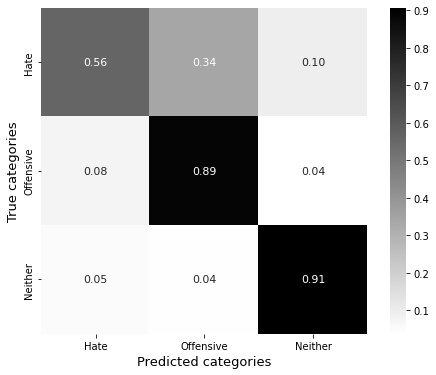

In [35]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds_logreg)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']

confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

plt.figure(figsize=(8,6))
seaborn.heatmap(confusion_df,annot=True, square=True,fmt='.2f', annot_kws={"size": 11}, cmap='gist_gray_r')
plt.ylabel('True categories',fontsize=13)
plt.xlabel('Predicted categories',fontsize=13)

# plt.savefig('confusion_logreg.png')

##### Confusion Matrix SVM

Text(0.5, 33.0, 'Predicted categories')

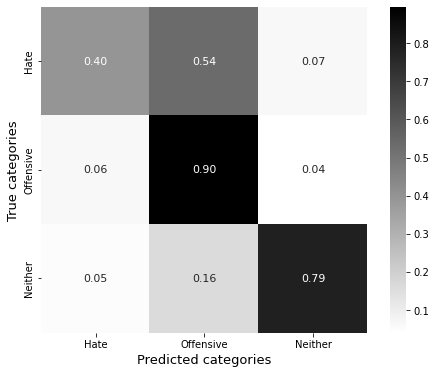

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_preds_svm)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']

confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

plt.figure(figsize=(8,6))
seaborn.heatmap(confusion_df,annot=True, square=True,fmt='.2f', annot_kws={"size": 11}, cmap='gist_gray_r')
plt.ylabel('True categories',fontsize=13)
plt.xlabel('Predicted categories',fontsize=13)

# plt.savefig('confusion_logreg.png')

### Post-hoc Model Interpretability

#### SHAP using the best model (logreg)
TODO: LIME (Local Interpretable Model-Agnostic Explanations)

In [37]:
# sampling data from the training and test set to reduce time-taken
X_train_sample = shap.sample(X_train, 50)
X_test_sample = shap.sample(X_test, 10)

# creating the KernelExplainer using the logistic regression model and training sample
SHAP_explainer = shap.KernelExplainer(model.predict, X_train_sample)
# calculating the shap values of the test sample using the explainer
shap_vals = SHAP_explainer.shap_values(X_test_sample)


100%|██████████| 10/10 [10:50<00:00, 65.01s/it]


In [38]:
# converting the test samples to a dataframe 
# this is necessary for non-tabular data in order for the visualisations 
# to include feature value
colour_test = pd.DataFrame(X_test_sample)


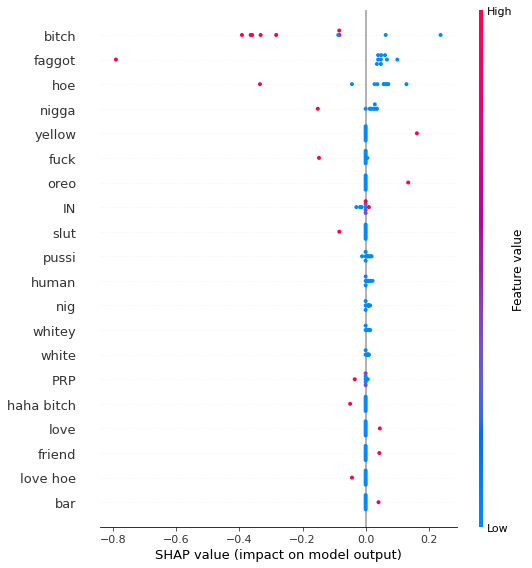

In [39]:
# y_ = df['class'].astype(int)
# X_ = df.drop(columns='class')
# X_train_, X_test_, y_train_, y_test_ = train_test_split(df, y_, random_state=42, test_size=0.1)
# X_test_
shap.summary_plot(shap_vals, colour_test, feature_names=feature_names)
# tfidf

In [40]:
shap.initjs()
shap.force_plot(SHAP_explainer.expected_value, shap_vals[1,:], colour_test.iloc[1,:], feature_names=feature_names)